# Sentiment Analysis of IMDB Movie Reviews

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

使用不同的分类模型来预测基于情感的正面评论和负面评论的数量。

**Import necessary libraries**

In [1]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from joblib import Parallel, delayed
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings('ignore')


['IMDB Dataset.csv']


**Import the training dataset 数据加载**



In [2]:
#importing the training data
imdb_data=pd.read_csv('../input/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


**Exploratery data analysis 数据探索**

In [3]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


**Sentiment count**

In [4]:
#sentiment count
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

We can see that the dataset is balanced.

数据集是平衡的

**Spliting the training dataset 划分数据集**

In [5]:
#split the dataset  
#train dataset
train_reviews=imdb_data.review[:40000]
train_sentiments=imdb_data.sentiment[:40000]
#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiments=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

## Data pre-processing 数据预处理
在情感分析项目中，数据预处理主要做文本规范化（Text normalization）。数据预处理是一个关键步骤，旨在将原始文本数据转换为适合模型输入的格式

**Removing html strips and square brackets 移除HTML标签和方括号及其内容**

Wall time: 13.1 s

In [7]:
%%time
#Removing the noisy text
def denoise_text(text):
    #Removing the html strips
    text = BeautifulSoup(text, "html.parser").get_text()
    #Removing the square brackets
    text = re.sub('\[[^]]*\]', '', text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

CPU times: user 9.96 s, sys: 74.3 ms, total: 10 s
Wall time: 10 s


**Removing special characters 移除特殊字符**

The original author made a small error in the code:

`pattern=r'[^a-zA-z0-9\s]'`

It should be corrected to:

`pattern=r'[^a-zA-Z0-9\s]'`

The lowercase 'z' should be changed to the uppercase 'Z'.

原作者有一个代码小错误：
pattern=r'[^a-zA-z0-9\s]'
应该改为
pattern=r'[^a-zA-Z0-9\s]'
z由小写改为大写Z

Wall time: 2.84 s

In [8]:
%%time
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-Z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

CPU times: user 1.42 s, sys: 6.85 ms, total: 1.42 s
Wall time: 1.42 s


**Text stemming 文本词干提取**




Since the original code took 6 minutes and 37 seconds, it felt a bit slow, so I attempted some optimization methods below to improve the speed.

因为原文这段代码耗时6min 37s，感觉有点慢，所以下面尝试了一些优化方法来提升速度
```powershell
CPU times: user 6min 37s, sys: 0 ns, total: 6min 37s
Wall time: 6min 37s
```

In [9]:
# %%time
# #Stemming the text
# def simple_stemmer(text):
#     ps=nltk.porter.PorterStemmer()
#     text= ' '.join([ps.stem(word) for word in text.split()])
#     return text
# #Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

After applying parallel computation using joblib, the time was optimized to 2 minutes and 43 seconds.

通过joblib来并行计算后，优化到了2min 43s

```powershell
CPU times: user 16.8 s, sys: 1.38 s, total: 18.2 s
Wall time: 2min 43s
```

In [10]:
%%time
#Stemming the text

# 初始化 PorterStemmer
ps=nltk.porter.PorterStemmer()

# 定义优化后的词干提取函数
def simple_stemmer(text):
    return ' '.join([ps.stem(word) for word in text.split()])

# 并行处理函数
def parallelize_dataframe(df, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(text) for text in df)

# 假设 imdb_data['review'] 是评论列
# 使用并行处理对每个评论应用词干提取函数
imdb_data['review'] = parallelize_dataframe(imdb_data['review'], simple_stemmer)

CPU times: user 11.3 s, sys: 636 ms, total: 11.9 s
Wall time: 2min 3s


Replace NLTK with spaCy to accelerate text stemming.

用spaCy来替代nltk，从而加速文本词干提取。

The result was not ideal; it would take over 10 minutes to complete the run.

效果不理想，如果跑完要花费超过10min

```powershell
 11%|█         | 5595/50000 [01:20<10:39, 69.46it/s]
```

In [11]:
# %%time
# import spacy
# from tqdm import tqdm

# # 确保下载了所需的spaCy模型，例如en_core_web_sm
# # 你可以在命令行中运行以下命令来下载：
# # python -m spacy download en_core_web_sm

# # 加载spaCy模型，禁用不必要的组件以加快处理速度
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# # 定义词形还原函数
# def lemmatize_text(text):
#     doc = nlp(text)
#     return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

# # 使用tqdm显示进度条，处理数据集
# tqdm.pandas()

# # 假设 imdb_data 是你的DataFrame，'review' 是评论列
# imdb_data['review'] = imdb_data['review'].progress_apply(lemmatize_text)



Utilize spaCy's batch processing feature for further optimization.

使用spaCy的批处理功能来进一步优化

The result is still not ideal; it would still take over 10 minutes to complete the run.

效果还是不理想，如果跑完仍然要花费超过10min
```powershell
 10%|█         | 5/50 [01:15<11:25, 15.23s/it]
```

I tried changing the `batch_size` from 1000 to 5000, but it didn't have much effect; instead, it became slightly slower.

尝试把batch_size从1000修改为5000，还是没有什么效果，反而更慢了一点
```powershell
10%|█         | 1/10 [01:25<12:52, 85.83s/it]
```


In [12]:
# %%time
# import spacy
# from tqdm import tqdm

# # 加载spaCy模型，禁用不必要的组件
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# # 定义批处理的大小
# batch_size = 5000

# # 定义批处理函数
# def batch_lemmatize(texts):
#     docs = nlp.pipe(texts, batch_size=batch_size)
#     return [' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space]) for doc in docs]

# # 处理数据集并应用词形还原
# reviews = imdb_data['review'].tolist()
# lemmatized_reviews = []

# for i in tqdm(range(0, len(reviews), batch_size)):
#     batch = reviews[i:i + batch_size]
#     lemmatized_batch = batch_lemmatize(batch)
#     lemmatized_reviews.extend(lemmatized_batch)

# imdb_data['review'] = lemmatized_reviews


Since spaCy version 2.x was being used, manual parallel processing had to be implemented, which reduced the time to 4 minutes and 35 seconds. However, this is still slower than NLTK's batch processing time of 2 minutes and 41 seconds, so I decided to abandon using spaCy to replace NLTK.

因为使用的是 spaCy 2.x 版本，所以需要手动实现并行处理，时间缩短为4min 35s，但还是慢于nltk的批处理时间（2min 41s），所以放弃使用spaCy来替代nltk
```powershell
CPU times: user 9.82 s, sys: 3.39 s, total: 13.2 s
Wall time: 4min 35s
```


In [13]:
# %%time
# import spacy
# from multiprocessing import Pool

# # 仍然加载 spaCy 的语言模型，但不使用并行化参数
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])

# def lemmatize_text(text):
#     doc = nlp(text)
#     return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

# def parallel_lemmatize(texts, num_processes):
#     with Pool(num_processes) as pool:
#         results = list(pool.imap(lemmatize_text, texts))
#     return results

# reviews = imdb_data['review'].tolist()

# # 设置使用的进程数
# num_processes = 4  # 根据你的 CPU 核心数调整

# # 并行处理
# lemmatized_reviews = parallel_lemmatize(reviews, num_processes)

# imdb_data['review'] = lemmatized_reviews


**Removing stopwords 移除停用词**

```powershell
CPU times: user 1min 13s, sys: 26.2 ms, total: 1min 13s
Wall time: 1min 14s
```

In [14]:
# %%time
# #set stopwords to english
# stop=set(stopwords.words('english'))
# print(stop)

# #removing the stopwords
# def remove_stopwords(text, is_lower_case=False):
#     tokens = tokenizer.tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         filtered_tokens = [token for token in tokens if token not in stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
#     filtered_text = ' '.join(filtered_tokens)    
#     return filtered_text
# #Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

Using parallel computing reduced the time to remove stopwords.

使用并行计算缩短移除停用词的时间

The time was reduced from 1 minute and 14 seconds to 42 seconds.

时间从1min14s缩短为42s

```powershell
CPU times: user 5.18 s, sys: 162 ms, total: 5.34 s
Wall time: 42 s
```

In [15]:
%%time
import multiprocessing

# 设置停用词为英文
stop = set(stopwords.words('english'))

# 去除停用词的函数
def remove_stopwords(text, is_lower_case=False):
    tokens = word_tokenize(text)  # 使用 word_tokenize 分词
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
        
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# 并行化处理每一条评论
def parallel_apply(data, func, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(delayed(func)(text) for text in data)

# 将评论数据并行化处理
imdb_data['review'] = parallel_apply(imdb_data['review'], remove_stopwords, n_jobs=multiprocessing.cpu_count())

CPU times: user 3.16 s, sys: 113 ms, total: 3.27 s
Wall time: 26.6 s


**Normalized train reviews 拼写校正（已注释）**

In [16]:
#normalized train reviews
norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]
#convert dataframe to string
#norm_train_string=norm_train_reviews.to_string()
#Spelling correction using Textblob
#norm_train_spelling=TextBlob(norm_train_string)
#norm_train_spelling.correct()
#Tokenization using Textblob
#norm_train_words=norm_train_spelling.words
#norm_train_words

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

**Normalized test reviews 拼写校正（已注释）**

In [17]:
#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]
##convert dataframe to string
#norm_test_string=norm_test_reviews.to_string()
#spelling correction using Textblob
#norm_test_spelling=TextBlob(norm_test_string)
#print(norm_test_spelling.correct())
#Tokenization using Textblob
#norm_test_words=norm_test_spelling.words
#norm_test_words

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

## Feature Extraction 特征提取 

1.词袋模型、 TF-IDF和词嵌入 是文本分类任务中的特征提取部分，它们负责将文本数据转换为可用于模型训练的数值特征。这是文本分类项目中非常关键的一步，因为特征的质量直接影响到最终模型的性能。2.该项目只使用了词袋模型和TF-IDF模型。

**Bags of words model 词袋模型**

It is used to convert text documents to numerical vectors or bag of words.

```powershell
BOW_cv_train: (40000, 6208633)
BOW_cv_test: (10000, 6208633)
CPU times: user 1min 39s, sys: 2.73 s, total: 1min 42s
Wall time: 1min 42s
```


In [18]:
# %%time
# #Count vectorizer for bag of words
# cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
# #transformed train reviews
# cv_train_reviews=cv.fit_transform(norm_train_reviews)
# #transformed test reviews
# cv_test_reviews=cv.transform(norm_test_reviews)

# print('BOW_cv_train:',cv_train_reviews.shape)
# print('BOW_cv_test:',cv_test_reviews.shape)
# #vocab=cv.get_feature_names()-toget feature names

#### **Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

```powershell
Tfidf_train: (40000, 6208633)
Tfidf_test: (10000, 6208633)
CPU times: user 1min 46s, sys: 3.05 s, total: 1min 49s
Wall time: 1min 49s
```

In [19]:
# %%time
# #Tfidf vectorizer
# tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
# #transformed train reviews
# tv_train_reviews=tv.fit_transform(norm_train_reviews)
# #transformed test reviews
# tv_test_reviews=tv.transform(norm_test_reviews)
# print('Tfidf_train:',tv_train_reviews.shape)
# print('Tfidf_test:',tv_test_reviews.shape)

优化TFIDF的参数来提升预测的准确率

耗时从1min 49s减少到34.6 s

Wall time: 34.6 s

In [20]:
%%time
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=3, max_df=0.4, ngram_range=(1,2))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 297387)
Tfidf_test: (10000, 297387)
CPU times: user 31.5 s, sys: 1.19 s, total: 32.7 s
Wall time: 32.6 s


## Label Binarization 标签二值化处理

**二分类问题**：当你的数据有两个类别（如正面、负面）时，可以直接将其标签二值化，例如将“正面”映射为1，将“负面”映射为0。

**Labeling the sentiment text**

In [21]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


**Split the sentiment data**

In [22]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Training and evaluation of multiple models 
多个模型的训练、评估、结果分析和报告

### Logistic Regression Model 逻辑回归模型

**Modelling the dataset 用数据集训练模型**

Let us build logistic regression model for both bag of words and tfidf features

这段代码的核心工作是对文本分类任务中的两种不同特征（词袋模型和 TF-IDF 模型）分别训练逻辑回归分类器。通过 `fit` 方法，模型学习到如何根据输入的特征矩阵预测情感标签。

```powershell
CPU times: user 44.9 s, sys: 20.6 s, total: 1min 5s
Wall time: 28 s
```

In [23]:
%%time
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: user 8.22 s, sys: 5.85 s, total: 14.1 s
Wall time: 3.63 s


**Logistic regression model performane on test dataset**

逻辑回归模型在测试集上的表现

In [24]:
#Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

#预测结果是每个测试样本的情感标签：0或者1。

[0 0 0 ... 1 0 0]


**Accuracy of the model** 
准确率

In [25]:
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.8987


**Print the classification report** 分类报告

In [26]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)
# print(lr_tfidf_report.to_markdown()) 'str' object has no attribute 'to_markdown'

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.90      4993
    Negative       0.89      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Confusion matrix** 混淆矩阵

In [27]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4534  473]
 [ 540 4453]]


**Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features**

**SGD优化的LSVM模型**

耗时：3.34 s

In [28]:
%%time
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

#fitting the svm for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
CPU times: user 901 ms, sys: 208 ms, total: 1.11 s
Wall time: 741 ms


**Model performance on test data**

In [29]:
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 1 ... 1 0 0]


**Accuracy of the model**

In [30]:
#Accuracy score for tfidf features
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :",svm_tfidf_score)

svm_tfidf_score : 0.8949


**Print the classification report**

In [31]:
#Classification report for tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.91      0.88      0.89      4993
    Negative       0.88      0.91      0.90      5007

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



**Plot the confusion matrix**

In [32]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4552  455]
 [ 596 4397]]


**Multinomial Naive Bayes for bag of words and tfidf features**

**多项式朴素贝叶斯模型**

耗时：1.94 s

In [33]:
%%time
#training the model
mnb=MultinomialNB()

#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
CPU times: user 97 ms, sys: 90 µs, total: 97.1 ms
Wall time: 95.5 ms


**Model performance on test data**

In [34]:
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 0 0]


**Accuracy of the model**

In [35]:
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_tfidf_score : 0.889


**Print the classification report**

In [36]:
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.89      4993
    Negative       0.89      0.88      0.89      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



**Plot the confusion matrix**

In [37]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[4422  585]
 [ 525 4468]]


**Let us see positive and negative words by using WordCloud.**

**Word cloud for positive review words**

<function matplotlib.pyplot.show(*args, **kw)>

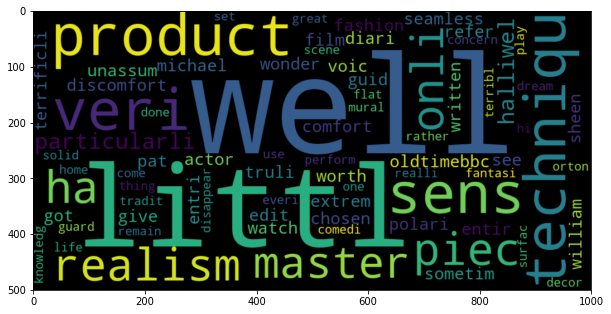

In [38]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

**Word cloud for negative review words**

<function matplotlib.pyplot.show(*args, **kw)>

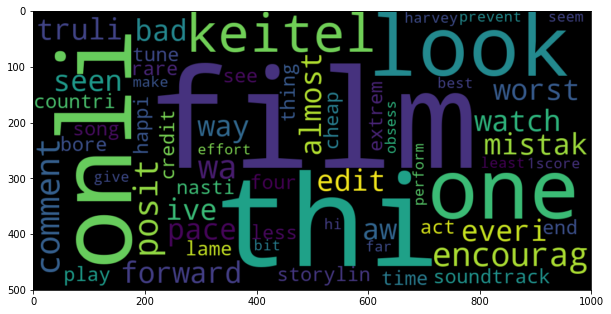

In [39]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

**Conclusion:**
* We can observed that both logistic regression and multinomial naive bayes model performing well compared to linear support vector  machines.
* Still we can improve the accuracy of the models by preprocessing data and by using lexicon models like Textblob.